## Imports

In [10]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("./Data/cleaned_govtrades.csv")
df["Estimated Holdings"] = df["Estimated Holdings"].str[1:].str.replace(",", "")
df["Estimated Holdings"] = df["Estimated Holdings"].astype(int)
df["Party"] = df["Senator"].str[-5]
df["State"] = df["Senator"].str[-3:-1]
df

,Senator,Estimated Holdings,Symbol,Company,Sector,Industry,Party,State
0,Susan Collins (R-ME),42333400,MMM,3M Company,Health Care,Medical/Dental Instruments,R,ME
1,Mark Warner (D-VA),23574100,BDJ,Blackrock Enhanced Equity Divid Trust,Finance,Investment Managers,D,VA
2,Mitch McConnell (R-KY),12320800,VFIAX,Vanguard 500 Index Admiral Fund,Finance,Investment Managers,R,KY
3,Dianne Feinstein (D-CA),9205300,CBRE,CBRE Group,Finance,Investment Managers,D,CA
4,Elizabeth Warren (D-MA),8439900,TRGIX,TIAA-CREF Growth & Income Retirement Fund,Finance,Investment Managers,D,MA
...,...,...,...,...,...,...,...,...
2491,Jerry Moran (R-KS),0,RIG,Transocean Ltd,Energy,Oil & Gas Drilling,R,KS
2492,John Boozman (R-AR),0,VCSH,Vanguard Short-term Corporate Bond,Finance,ETFs,R,AR
2493,Gary Peters (D-MI),0,MCC,Medley Capital Corp,Finance,Closed-End Funds,D,MI
2494,Patty Murray (D-WA),0,MET,MetLife Inc,Financial Services,Insurance - Life,D,WA


## GovTrades Analysis

### Which Sectors have Senators invested in?

In [5]:
def getSumCount(df, group_col, agg_col):
    grouped_holdings = df.groupby(group_col).agg({agg_col: ["sum", "count"]}).reset_index()
    grouped_holdings.columns = [' '.join(col).strip() for col in grouped_holdings.columns.values]
    return grouped_holdings

In [6]:
sector_holdings = getSumCount(df, "Sector", "Estimated Holdings")
sector_holdings

,Sector,Estimated Holdings sum,Estimated Holdings count
0,Basic Industries,1635600,89
1,Basic Materials,700,1
2,Capital Goods,77321000,54
3,Consumer Cyclical,1800,6
4,Consumer Defensive,900,2
5,Consumer Discretionary,600,2
6,Consumer Durables,456600,10
7,Consumer Non-Durables,5879700,166
8,Consumer Services,45995000,439
9,Consumer Staples,100,1


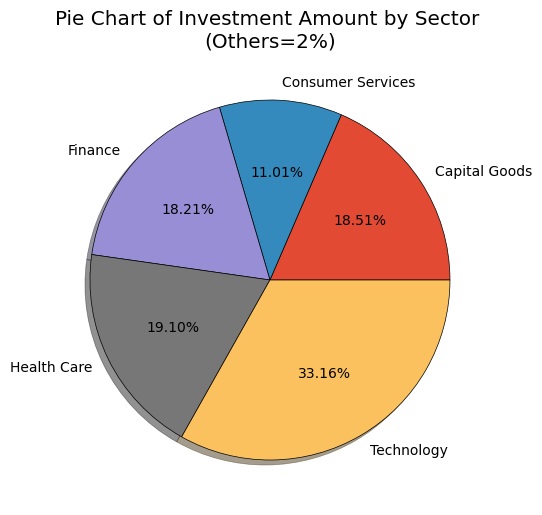

In [7]:
scale = 1e5
pie_sector_data = sector_holdings["Estimated Holdings sum"]/scale
pie_sector_data /= pie_sector_data.sum()
pie_sector_data *= 100
indices = pie_sector_data>2

with plt.style.context('ggplot'):
    _ = plt.pie(pie_sector_data[indices], labels = sector_holdings["Sector"][indices]
                , wedgeprops={"edgecolor": "black"}, autopct="%1.2f%%"
                , shadow=True)
    plt.tight_layout()
    plt.title("Pie Chart of Investment Amount by Sector \n(Others=2%)")
    plt.show()
plt.close()
# https://scc.ms.unimelb.edu.au/resources/data-visualisation-and-exploration/no_pie-charts

### How does Estimated Investment depend on the State the Senator is from?

In [3]:
state_holdings = df.groupby('State')['Estimated Holdings'].sum().reset_index()

In [4]:
scale = 1e5
fig = go.Figure(data=[
    go.Scattergeo(
    locationmode='USA-states',
    locations=state_holdings['State'],    
    text=(state_holdings['Estimated Holdings']/scale).round(2),
    showlegend=False,
    marker=dict(
        size=state_holdings['Estimated Holdings'] / scale, 
        color='skyblue',
        line=dict(width=1, color='DarkSlateGray'),
        sizemode='area',
        )

    ),
    go.Scattergeo(
        locationmode='USA-states',
        locations=state_holdings['State'],
        text=state_holdings['State'],  # State names near states
        mode='text',
        textposition='top left',  # State names above bubbles
        showlegend=False, #prevent legend from showing up.
    )
    ]
)

fig.update_layout(
    title_text='Estimated Holdings by State',
    geo=dict(
        scope='usa',
        # projection_type='albers usa',
        # showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)
fig.show()

### How  diversified are Senators' investements by Party?

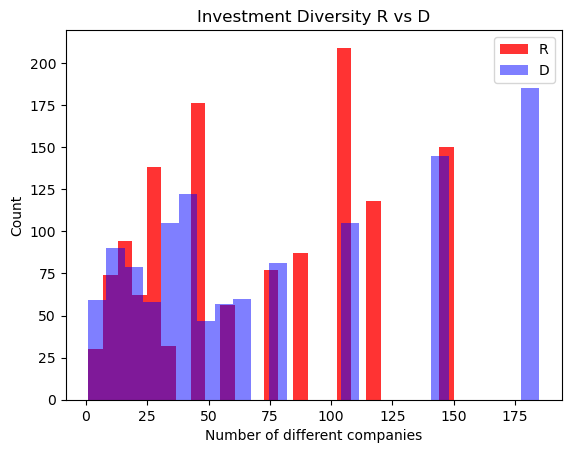

In [45]:
df_senator_party = df[["Senator", "Party"]]
df_senator_count_total = df.groupby("Senator").agg({"Party": "count"}).reset_index()
df_senator_count_total.columns = ["Senator", "Count"]
df_senator_count_total = pd.merge(df_senator_count_total, df_senator_party, on="Senator", how="left")

ra= plt.hist(df_senator_count_total[df_senator_count_total["Party"]=="R"]["Count"], histtype="bar", alpha=0.8, color="red", label="R", bins=25)
da= plt.hist(df_senator_count_total[df_senator_count_total["Party"]=="D"]["Count"], histtype="bar", alpha=0.5, color="blue", label="D", bins=25)
plt.legend()

plt.title("Investment Diversity R vs D")
plt.xlabel("Number of different companies")
plt.ylabel('Count')
plt.show()
plt.close()

In [ ]:
df_senator_count_r = df_senator_count_total[df_senator_count_total["Party"]=="R"]["Count"].reset_index()
df_senator_count_d = df_senator_count_total[df_senator_count_total["Party"]=="D"]["Count"].reset_index()

,index,Count
0,0,10
1,1,10
2,2,10
3,3,10
4,4,10
...,...,...
1188,2491,18
1189,2492,18
1190,2493,18
1191,2494,18


c:\Users\siddh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\siddh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



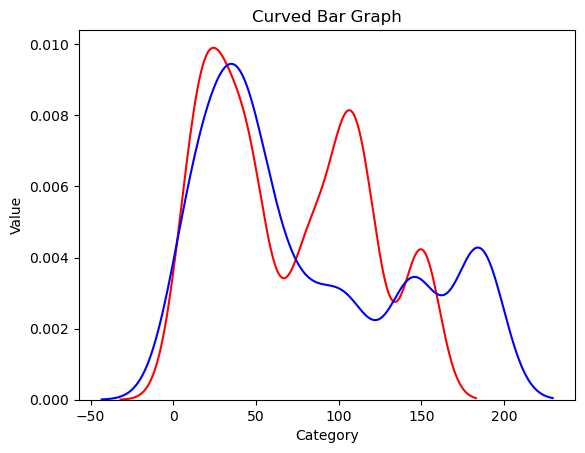

In [44]:
# fig, ax = plt.subplots()
sns.kdeplot(data=df_senator_count_r, x="Count", color="red")#, kind="kde"
sns.kdeplot(data=df_senator_count_d, x="Count", color="blue")#, kind="kde"
# sns.lineplot(x=ra[1][:-1], y=ra[0])

plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Curved Bar Graph')
plt.show()

## Stanford CA Analysis